In [1]:
# Random Imports
import os
import sys
import yaml
from pathlib import Path
from pprint import pprint
sys.path.append('/storage/vbutoi/projects')
sys.path.append('/storage/vbutoi/libraries')
sys.path.append('/storage/vbutoi/libraries/voxynth')
sys.path.append('/storage/vbutoi/projects/ESE')
sys.path.append('/storage/vbutoi/projects/UniverSegDev')

# Regular schema dictates that we put DATAPATH
os.environ['DATAPATH'] = ':'.join((
       '/storage/vbutoi/datasets',
))
os.environ['WANDB_NOTEBOOK_NAME'] = 'calibrate.ipynb'

# IonPy imports
from ionpy.util import Config

%load_ext yamlmagic
%load_ext autoreload
%autoreload 2

In [2]:
%%yaml default_cfg

experiment:
  val_first: True 
  torch_compile: True 
  torch_mixed_precision: False 

dataloader:
  batch_size: '?'
  num_workers: '?' 
  pin_memory: True 

optim: # Unclear if we should tune this or not.
  _class: torch.optim.Adam
  lr: '?'

train:
  epochs: '?'
  eval_freq: '?'
  base_pretrained_dir: '?'
  use_pretrained_norm_augs: True 
  base_checkpoint: 'max-val-dice_score'
  base_pt_select_metric: 'val-dice_score'

loss_func: 
  _class: '?'

<IPython.core.display.Javascript object>

In [3]:
%%yaml log_cfg

log:
  checkpoint_freq: 10
  root: '?'
  metrics:
    abs_area_estimation_error:
      _fn: ese.losses.area_estimation_error
      from_logits: True
      abs_diff: True

<IPython.core.display.Javascript object>

In [4]:
%%yaml callbacks_cfg

callbacks:
  step:
    - ese.callbacks.ShowPredictions
  epoch:
    - ese.callbacks.WandbLogger
    - ionpy.callbacks.ETA
    - ionpy.callbacks.JobProgress
    - ionpy.callbacks.TerminateOnNaN
    - ionpy.callbacks.PrintLogged
    - ionpy.callbacks.ModelCheckpoint:
        monitor: 
          - abs_area_estimation_error
        phase: val

<IPython.core.display.Javascript object>

In [5]:
%%yaml calibrator_defaults_cfg 

TS:
  _class: ese.models.calibrators.Temperature_Scaling

LTS:
  _class: ese.models.calibrators.LocalTS
  img_channels: 1
  num_classes: 1
  dims: '?'
  filters: [8, 8, 8]

3D_LTS_Huge:
  _class: ese.models.calibrators.LocalTS
  img_channels: 1
  num_classes: 1
  use_image: True
  abs_output: '?'
  dims: 3
  convs_per_block: 2
  filters: [64, 64, 64, 64, 64]

SCTS:
  _class: ese.models.resnet.SCTS
  dims: '?' 
  img_channels: 1
  num_classes: 1
  use_image: True 
  use_norm: True
  dims: 3
  # filters: [32, 32, 32]
  filters: [16, 16, 16]
  temp_range: (0.0, 3.0)
  blocks_per_layer: 2

E2T:
  _class: ese.models.peft.E2T
  in_features: 64
  num_classes: 1
  dims: 2
  features: [16, 16]
  temp_range: (0.0, 3.0)
  pool_fn: '?'


<IPython.core.display.Javascript object>

In [6]:
%%yaml aug_cfg

augmentations:
    spatial:
        max_translation: 5.0
        max_rotation: 5.0
        max_scaling: 1.1
        warp_integrations: 5
        warp_smoothing_range: [10, 20]
        warp_magnitude_range: [1, 3]
        affine_probability: 0.5
        warp_probability: 0.5

<IPython.core.display.Javascript object>

In [7]:
%%yaml experiment_cfg 

name: "OCTA_PredSweepSmall"

train: 
    base_pretrained_dir: "/storage/vbutoi/scratch/ESE/training/August_2024/08_07_24_OCTA_FULLRES_CrossEntropy/20240807_144627-M576-c3a81247e7e30c6bf47c72748764a898"

data:
    target: 
        - 'seg'
        # - 'volume'
        # - 'proportion'

model:
    class_name: E2T 
    # pool_fn: 'max'
    pool_fn: 'mean'
  
optim:
    lr: 1.0e-4

dataloader:
    batch_size: 1
    num_workers: 1

loss_func:
    _class: ese.losses.AreaEstimationError 
    square_diff: True
    from_logits: True

<IPython.core.display.Javascript object>

In [8]:
from ese.analysis.analysis_utils.submit_utils import get_ese_calibration_configs

# Get the configs for the different runs.
base_cfg = Config(default_cfg).update([log_cfg, callbacks_cfg])

# For exp management, need a add_date variable because we reuse for func calls below.
add_date = True 
# Build the calibration configs from the options + base
updated_base_cfg, cal_cfgs = get_ese_calibration_configs(
    exp_cfg=experiment_cfg,
    base_cfg=base_cfg,
    calibration_model_cfgs=calibrator_defaults_cfg,
    add_date=add_date
)

No base config found. Using base data config for: OCTA_6M.


In [9]:
len(cal_cfgs)

1

## Running Jobs

In [10]:
from ese.experiment import run_ese_exp, submit_ese_exps, PostHocExperiment

Intel MKL extensions not available for NumPy

Using slow Pillow instead of Pillow-SIMD

Set seed: 40


Intel MKL extensions not available for NumPy

Using slow Pillow instead of Pillow-SIMD

Loading checkpoint: max-val-dice_score.
Running PostHocExperiment("/storage/vbutoi/scratch/ESE/calibration/debug/20241017_001233-2XN9-9ceef6771430f17b646b33245ef638cb")
---
callbacks:
  epoch:
  - ionpy.callbacks.ETA
  - ionpy.callbacks.JobProgress
  - ionpy.callbacks.TerminateOnNaN
  - ionpy.callbacks.PrintLogged
  - ionpy.callbacks.ModelCheckpoint:
      monitor:
      - abs_area_estimation_error
      phase: val
  step:
  - ese.callbacks.ShowPredictions
data:
  in_channels: 1
  label: 255
  label_threshold: 0.5
  out_channels: 1
  target: seg
  train_kwargs:
    iters_per_epoch: 1000
    split: cal
  val_kwargs:
    split: val
  version: 1.0
dataloader:
  batch_size: 1
  num_workers: 1
  pin_memory: true
experiment:
  seed: 40
  torch_compile: true
  torch_mixed_precision: false
  val_first: true
log:
  checkpoint_freq: 10
  metrics:
    abs_area_estimation_error:
      _fn: ese.losses.area_estimation_error
      abs_diff: true
      from_logits: true
  root: /storage/vbutoi/scratch

W1017 00:12:37.124737 140213499451200 torch/_dynamo/variables/builtin.py:775] [0/0] incorrect arg count <bound method BuiltinVariable.call_enumerate of BuiltinVariable()> got an unexpected keyword argument 'start' and no constant handler


tensor([[1.550]], device='cuda:0')
Loss:  93812504.0


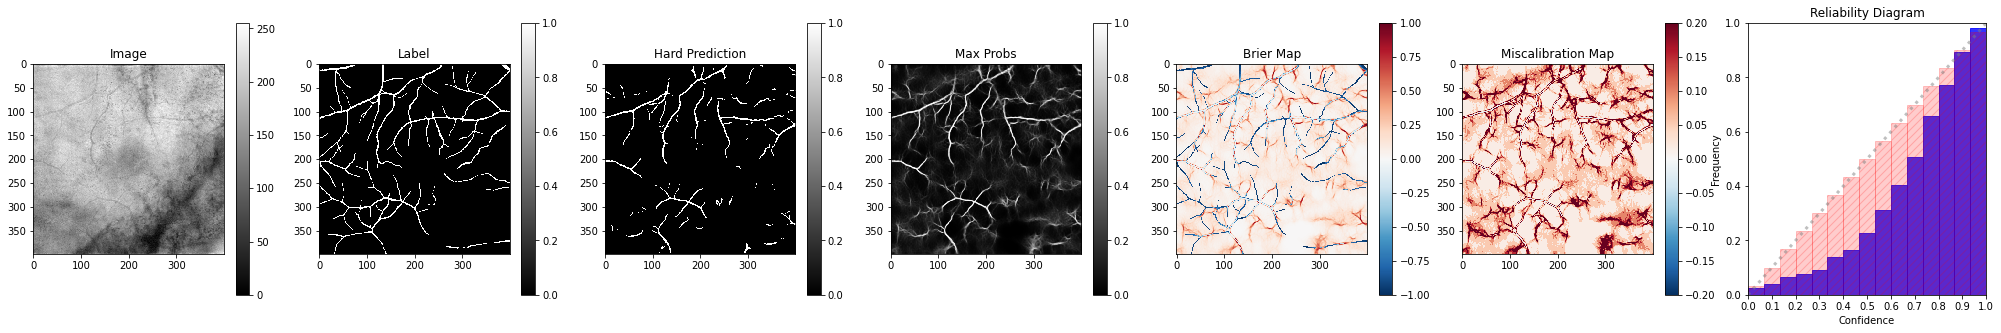

tensor([[1.551]], device='cuda:0')
Loss:  14396452.0


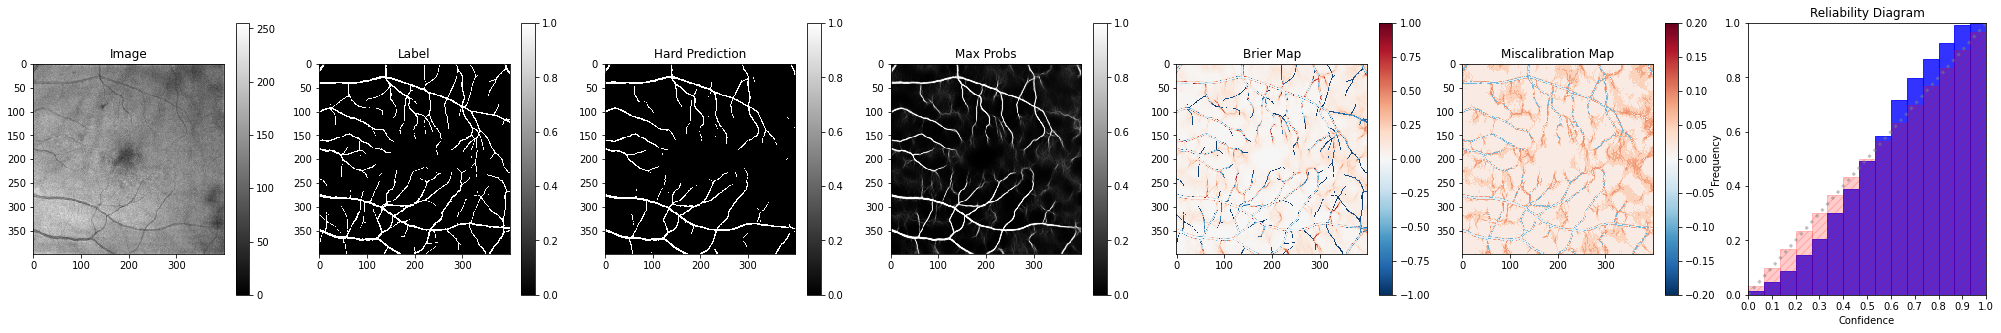

tensor([[1.551]], device='cuda:0')
Loss:  7355293.5


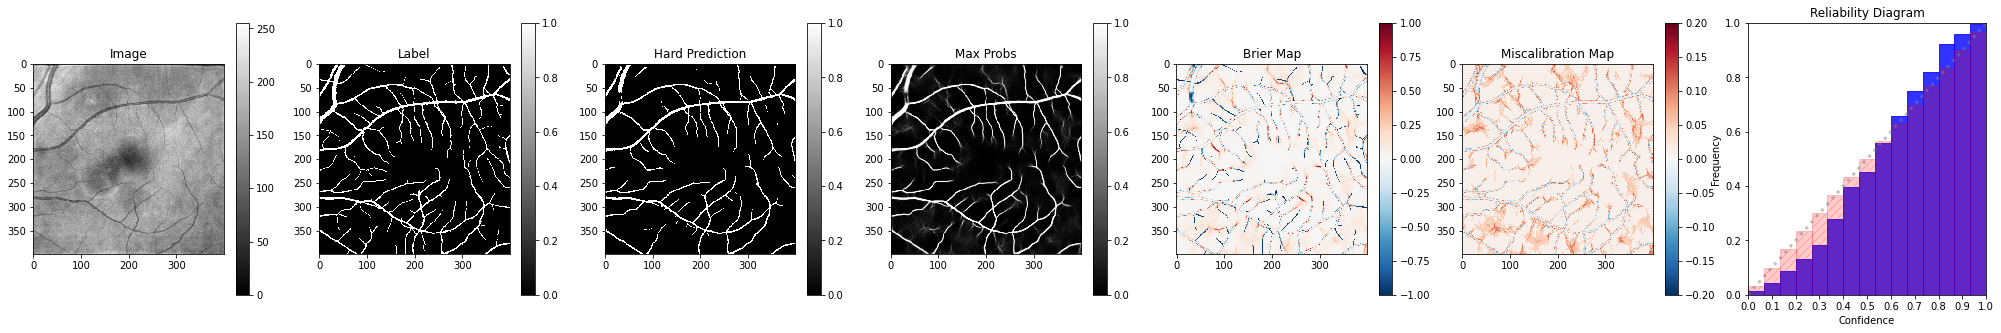

tensor([[1.551]], device='cuda:0')
Loss:  25811956.0


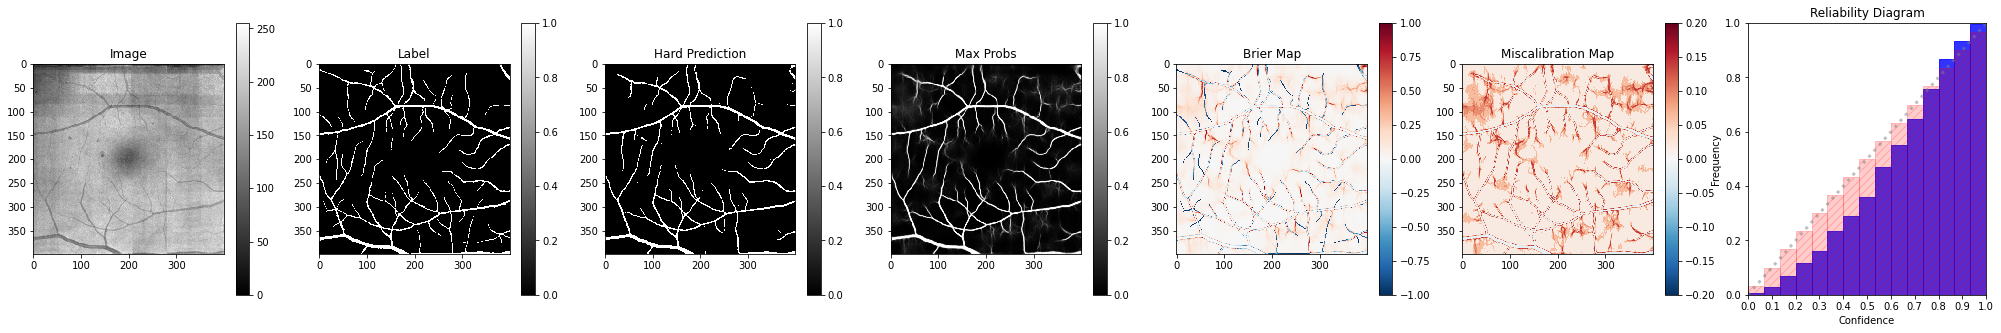

tensor([[1.551]], device='cuda:0')
Loss:  2843557.75


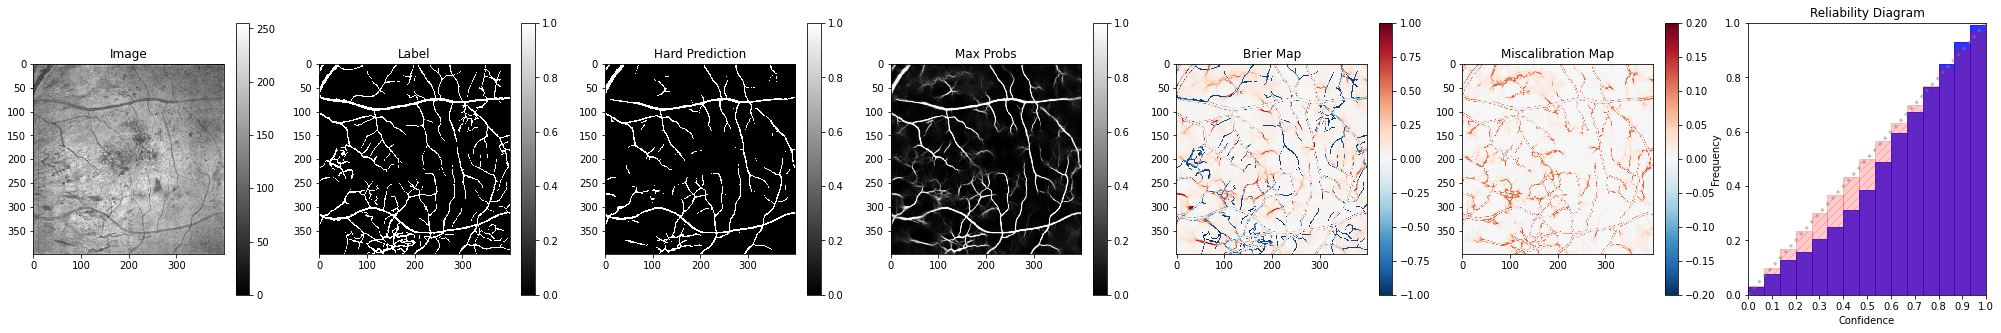

tensor([[1.551]], device='cuda:0')
Loss:  9680290.0


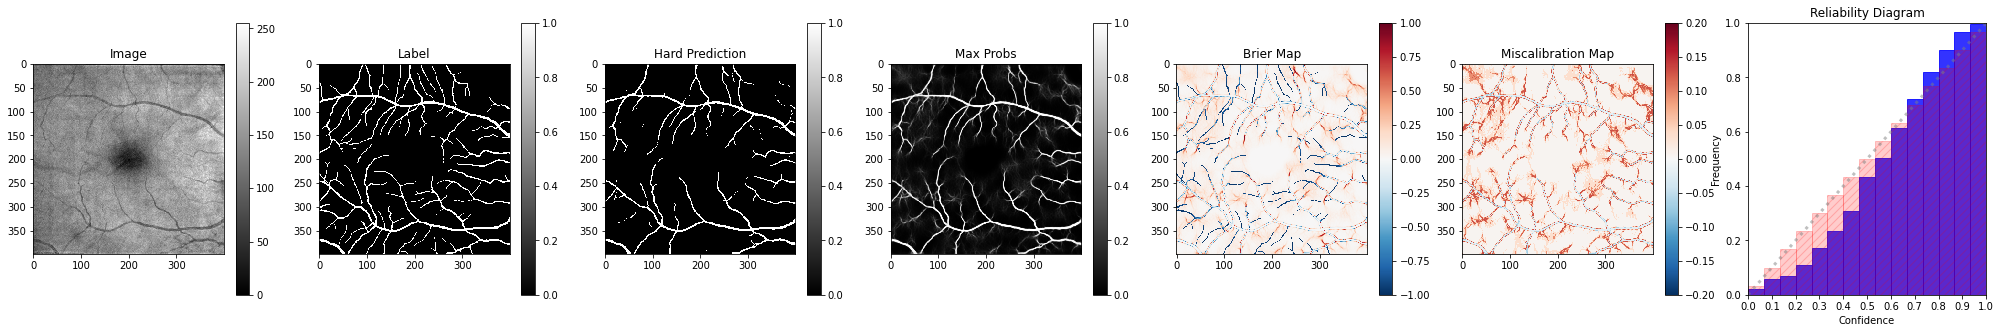

tensor([[1.550]], device='cuda:0')
Loss:  40907392.0


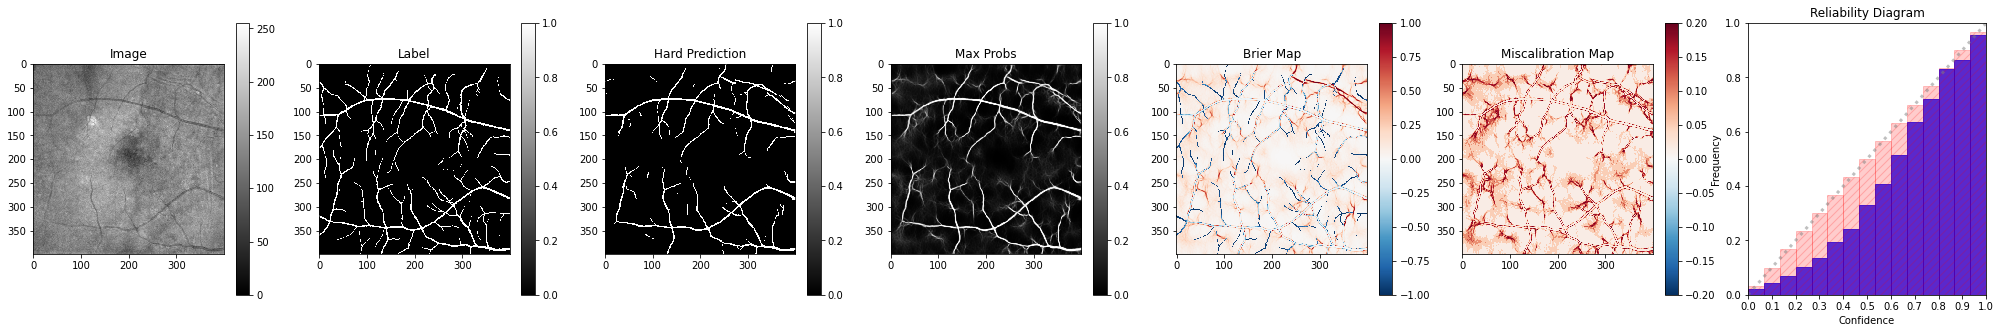

tensor([[1.550]], device='cuda:0')
Loss:  32222608.0


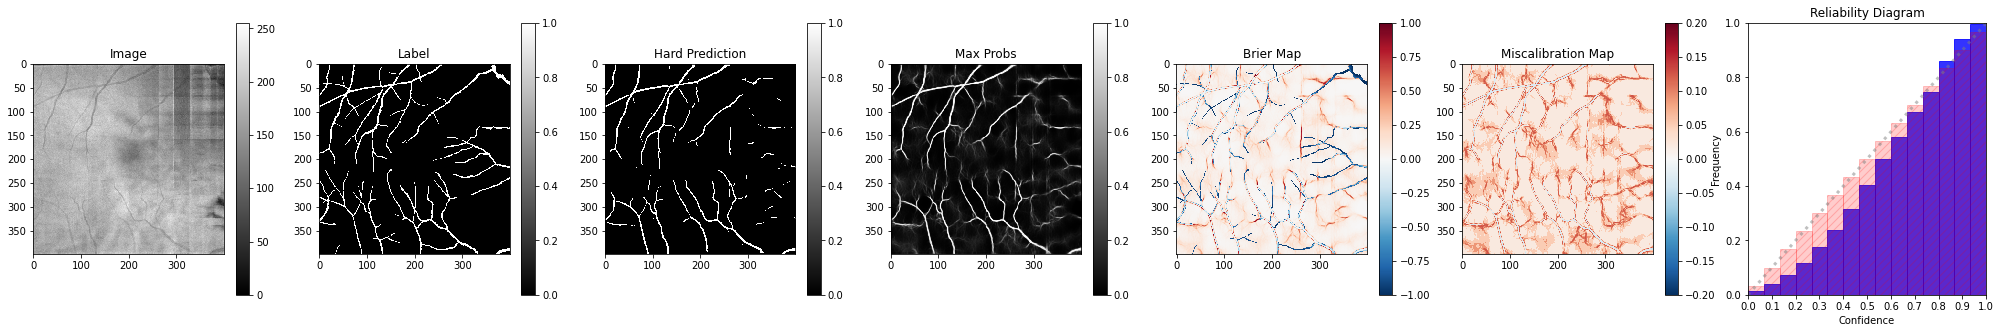

tensor([[1.550]], device='cuda:0')
Loss:  80479504.0


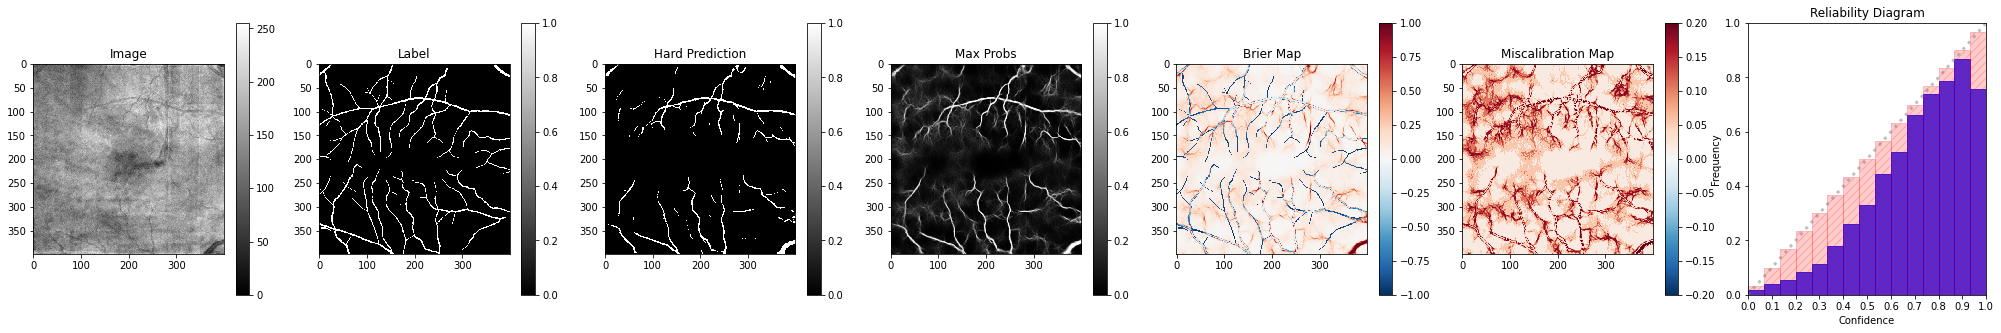

tensor([[1.551]], device='cuda:0')
Loss:  15584807.0


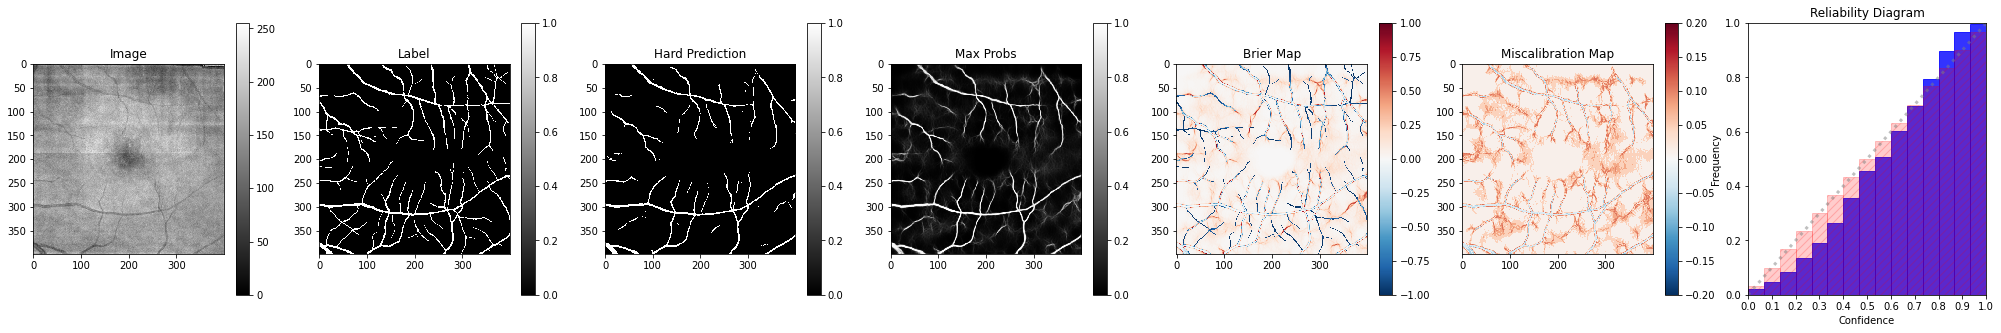

tensor([[1.551]], device='cuda:0')
Loss:  10178468.0


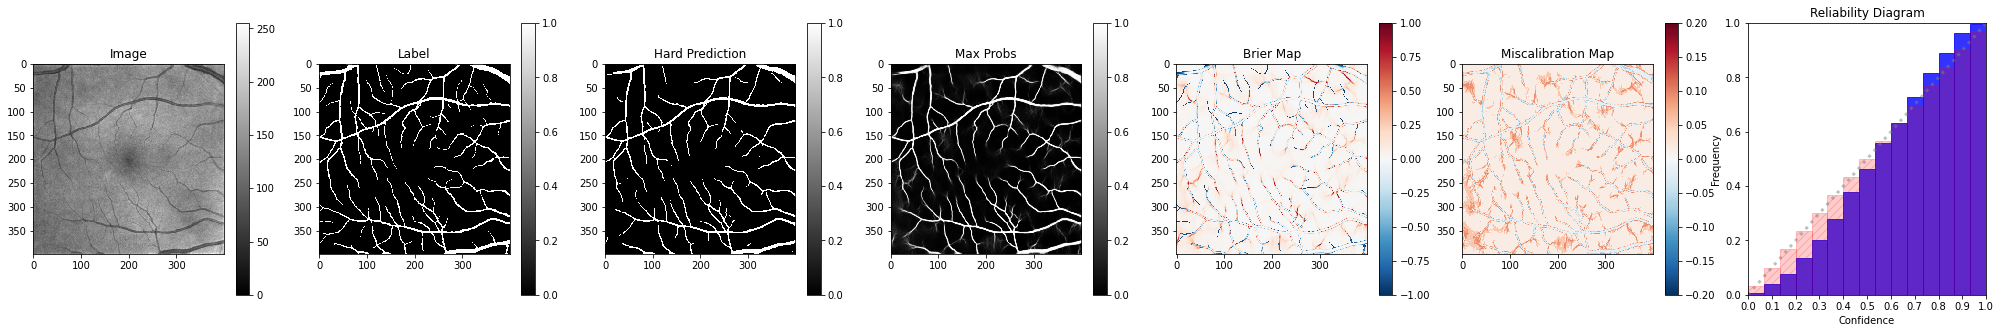

tensor([[1.550]], device='cuda:0')
Loss:  33222570.0


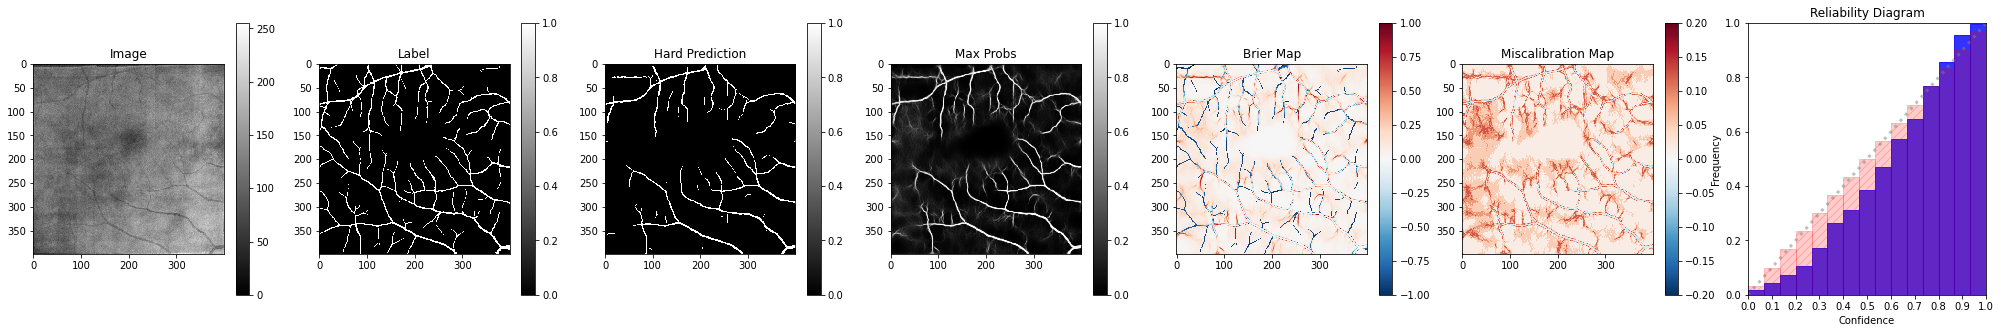

tensor([[1.550]], device='cuda:0')
Loss:  24476596.0


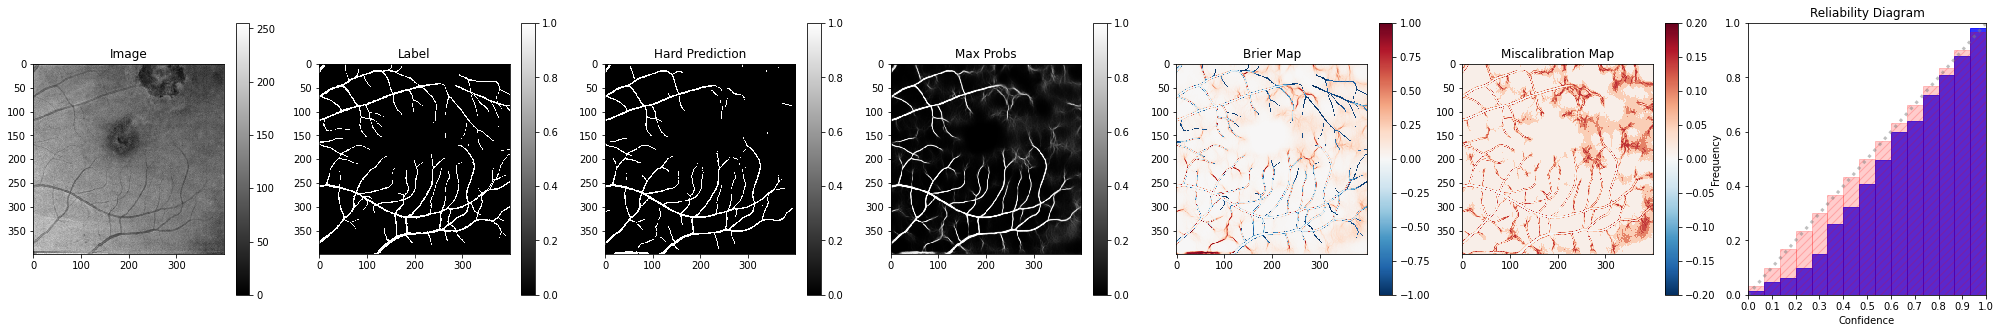

tensor([[1.550]], device='cuda:0')
Loss:  42205628.0


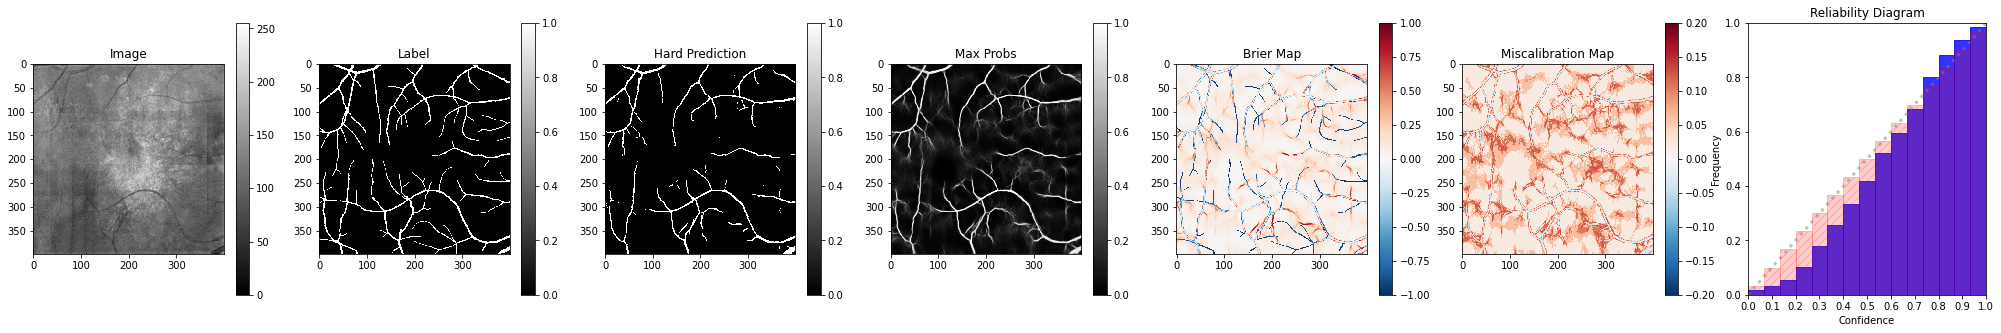

tensor([[1.550]], device='cuda:0')
Loss:  19527630.0


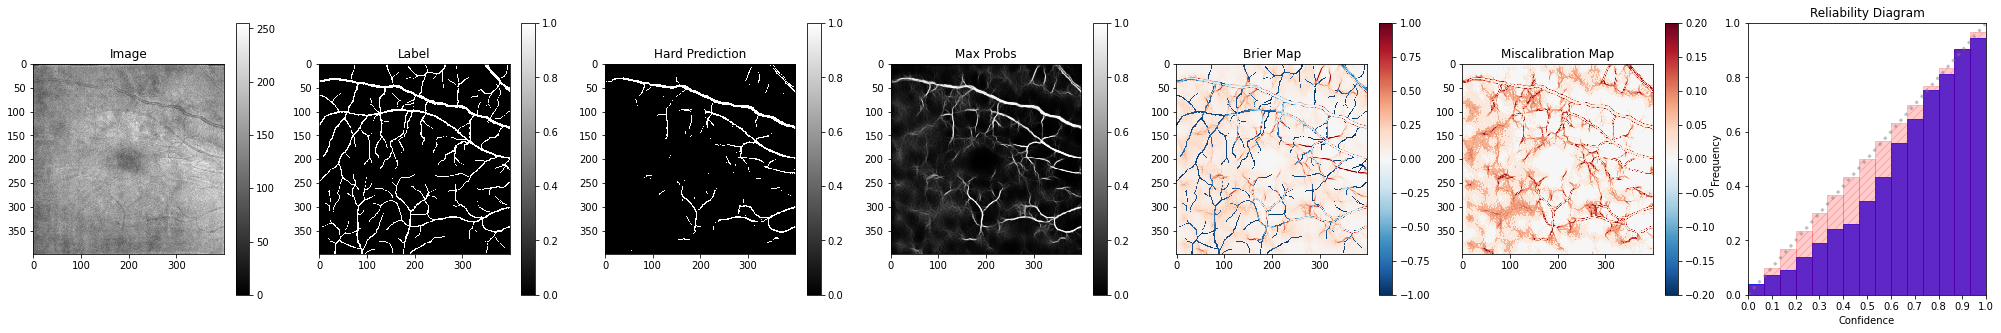

tensor([[1.551]], device='cuda:0')
Loss:  4659881.0


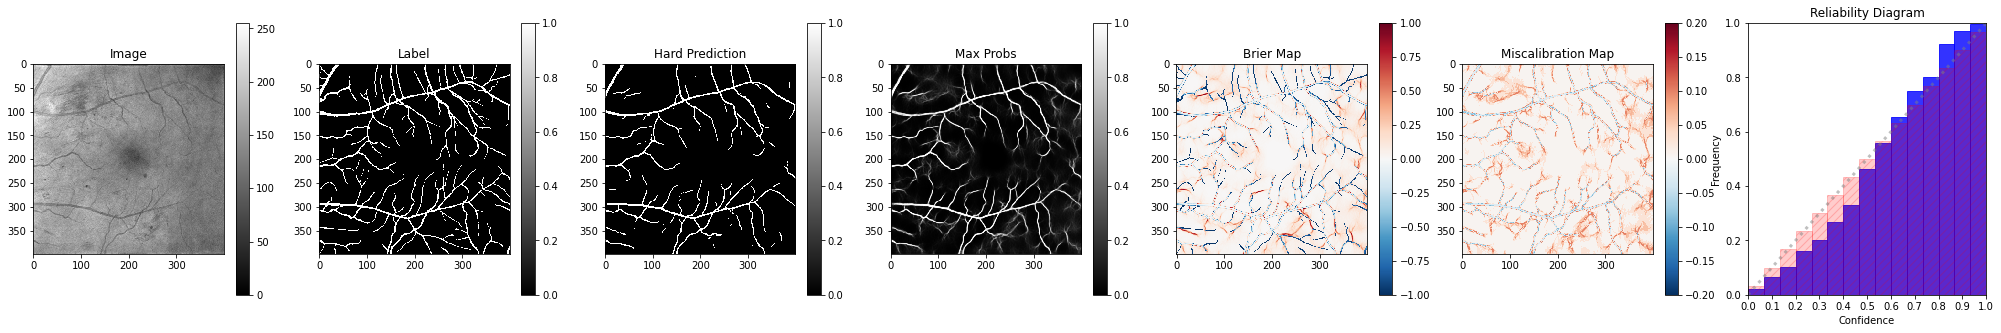

tensor([[1.550]], device='cuda:0')
Loss:  29207986.0


KeyboardInterrupt: 

In [11]:
####### Run individual jobs
run_ese_exp(
    config=cal_cfgs[0], 
    experiment_class=PostHocExperiment,
    run_name='debug',
    show_examples=True,
    track_wandb=False,
    gpu='4'
)

In [ ]:
# ### Run Batch Jobs
# submit_ese_exps(
#     group="calibration",
#     base_cfg=updated_base_cfg,
#     exp_cfg=experiment_cfg,
#     config_list=cal_cfgs,
#     experiment_class=PostHocExperiment,
#     add_date=add_date,
#     track_wandb=True,
#     available_gpus=['0', '1', '2']
# )